In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------------------------------
# Sinusoidal timestep embedding (like in DDPM)
# -------------------------------------------------
def timestep_embedding(timesteps, dim):
    """
    timesteps: (B,) int64 tensor
    dim: embedding dimension
    returns: (B, dim) float tensor
    """
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, device=device).float() / half
    )  # (half,)
    # shape: (B, half)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1))
    return emb


# -------------------------------------------------
# Simple MLP-based epsilon-predictor for diffusion
# Inputs:
#   noisy_waypoints: (B, T*D)
#   cond:            (B, C)
#   t:               (B,) timestep
# Output:
#   predicted noise: (B, T*D)
# -------------------------------------------------
class WaypointDiffusionModel(nn.Module):
    def __init__(self, waypoint_dim, cond_dim, hidden_dim=512, time_emb_dim=128):
        """
        waypoint_dim: T * D  (flattened waypoints)
        cond_dim: dimension of conditioning vector
        """
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, hidden_dim),
            nn.SiLU(),
        )

        self.fc1 = nn.Linear(waypoint_dim + cond_dim + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, waypoint_dim)

        self.time_emb_dim = time_emb_dim

    def forward(self, x_noisy, cond, t):
        """
        x_noisy: (B, waypoint_dim)
        cond:   (B, cond_dim)
        t:      (B,) int64
        """
        t_emb = timestep_embedding(t, self.time_emb_dim)
        t_feat = self.time_mlp(t_emb)

        h = torch.cat([x_noisy, cond, t_feat], dim=-1)
        h = F.silu(self.fc1(h))
        h = F.silu(self.fc2(h))
        eps_pred = self.fc3(h)
        return eps_pred

class GaussianDiffusion:
    def __init__(
        self,
        model: nn.Module,
        waypoint_dim: int,
        timesteps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
        device: str = "cuda",
    ):
        self.model = model.to(device)
        self.device = device
        self.waypoint_dim = waypoint_dim
        self.timesteps = timesteps

        # Linear beta schedule
        betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffers(betas, alphas, alphas_cumprod)

    def register_buffers(self, betas, alphas, alphas_cumprod):
        # Move to device
        self.betas = betas.to(self.device)                          # (T,)
        self.alphas = alphas.to(self.device)                        # (T,)
        self.alphas_cumprod = alphas_cumprod.to(self.device)        # (T,)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)  # (T,)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(
            1.0 - self.alphas_cumprod
        )                                                            # (T,)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)      # (T,)

        # For posterior variance: 
        # alpha_bar_prev[0] = 1, alpha_bar_prev[t] = prod_{i< t} alpha_i
        alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.device), self.alphas_cumprod[:-1]],
            dim=0,
        )  # (T,)

        # β_t * (1 - ᾱ_{t-1}) / (1 - ᾱ_t)
        self.posterior_variance = (
            self.betas
            * (1.0 - alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod)
        )  # (T,)

    # ----------------------
    # Forward diffusion q(x_t | x_0)
    # ----------------------
    def q_sample(self, x0, t, noise=None):
        """
        x0: (B, waypoint_dim)
        t:  (B,) int64
        returns x_t
        """
        if noise is None:
            noise = torch.randn_like(x0)

        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].unsqueeze(-1)           # (B,1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(-1)

        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

    # ----------------------
    # Training loss (epsilon prediction)
    # ----------------------
    def training_loss(self, x0, cond):
        """
        x0:   (B, waypoint_dim) - ground truth waypoints
        cond: (B, cond_dim)
        """
        B = x0.size(0)
        t = torch.randint(0, self.timesteps, (B,), device=self.device).long()

        noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise=noise)

        eps_pred = self.model(x_t, cond, t)
        loss = F.mse_loss(eps_pred, noise)
        return loss

    # ----------------------
    # One reverse step p(x_{t-1} | x_t)
    # ----------------------
    @torch.no_grad()
    def p_sample(self, x_t, cond, t):
        """
        x_t:   (B, waypoint_dim)
        cond: (B, cond_dim)
        t:    int timestep
        """
        b = x_t.size(0)
        t_batch = torch.full((b,), t, device=self.device, dtype=torch.long)
        eps_theta = self.model(x_t, cond, t_batch)

        beta_t = self.betas[t]                                   # scalar
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t]
        sqrt_recip_alpha_t = self.sqrt_recip_alphas[t]

        # DDPM mean:
        # μ_t = 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * eps_theta)
        x_prev_mean = sqrt_recip_alpha_t * (
            x_t - (beta_t / sqrt_one_minus_alpha_cumprod_t) * eps_theta
        )

        posterior_var_t = self.posterior_variance[t]

        if t > 0:
            noise = torch.randn_like(x_t)
            x_prev = x_prev_mean + torch.sqrt(posterior_var_t) * noise
        else:
            # last step, no noise
            x_prev = x_prev_mean

        return x_prev

    # ----------------------
    # Full sampling loop
    # ----------------------
    @torch.no_grad()
    def sample(self, cond, num_steps=None):
        """
        cond:      (B, cond_dim)
        num_steps: optional different number of diffusion steps for sampling
        returns:   (B, waypoint_dim)
        """
        if num_steps is None:
            num_steps = self.timesteps

        B = cond.size(0)
        x_t = torch.randn(B, self.waypoint_dim, device=self.device)

        for t in reversed(range(num_steps)):
            x_t = self.p_sample(x_t, cond, t)

        return x_t


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


class WaypointDataset(Dataset):
    def __init__(self, data):
        """
        data: list of dicts like:
              {"waypoints": (T, D), "cond": (C,)}
        You can adapt this to your format.
        """
        self.data = data

        # Infer sizes
        sample = data[0]
        self.T, self.D = sample["waypoints"].shape
        self.C = sample["cond"].shape[0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        waypoints = torch.tensor(item["waypoints"], dtype=torch.float32)  # (T, D)
        cond = torch.tensor(item["cond"], dtype=torch.float32)            # (C,)
        # Flatten waypoints
        waypoints = waypoints.view(-1)  # (T*D,)
        return waypoints, cond


# ------------------ Setup ------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: replace with your real dataset
dummy_data = [
    {
        "waypoints": torch.randn(10, 3).numpy(),  # T=10, D=3
        "cond": torch.randn(16).numpy(),          # cond_dim=16
    }
    for _ in range(1000)
]

dataset = WaypointDataset(dummy_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

waypoint_dim = dataset.T * dataset.D
cond_dim = dataset.C

model = WaypointDiffusionModel(
    waypoint_dim=waypoint_dim,
    cond_dim=cond_dim,
    hidden_dim=512,
    time_emb_dim=128,
)

diffusion = GaussianDiffusion(
    model=model,
    waypoint_dim=waypoint_dim,
    timesteps=1000,
    device=device,
)

optimizer = optim.Adam(diffusion.model.parameters(), lr=1e-4)


# ------------------ Training loop ------------------
for epoch in range(10):
    for batch_idx, (waypoints, cond) in enumerate(dataloader):
        waypoints = waypoints.to(device)
        cond = cond.to(device)

        optimizer.zero_grad()
        loss = diffusion.training_loss(waypoints, cond)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx} Loss {loss.item():.4f}")


Epoch 0 Batch 0 Loss 1.0256
Epoch 1 Batch 0 Loss 0.9662
Epoch 2 Batch 0 Loss 1.0373
Epoch 3 Batch 0 Loss 0.9362
Epoch 4 Batch 0 Loss 0.9142
Epoch 5 Batch 0 Loss 0.9050
Epoch 6 Batch 0 Loss 0.8815
Epoch 7 Batch 0 Loss 0.8547
Epoch 8 Batch 0 Loss 0.7806
Epoch 9 Batch 0 Loss 0.6487


In [5]:
diffusion.model.eval()

# Example: sample for some conditions
with torch.no_grad():
    cond = torch.randn(4, cond_dim).to(device)  # 4 different conditions
    samples = diffusion.sample(cond)            # (4, waypoint_dim)
    samples = samples.view(4, dataset.T, dataset.D)  # (4, T, D)

print("Sampled waypoints shape:", samples.shape)


Sampled waypoints shape: torch.Size([4, 10, 3])


In [7]:
import matplotlib.pyplot as plt

def visualize_waypoints_2d(waypoints, title="Waypoints"):
    """
    waypoints: (T, 2) numpy or torch
    """
    if hasattr(waypoints, "detach"):
        waypoints = waypoints.detach().cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(waypoints[:, 0], waypoints[:, 1], marker="o")
    plt.scatter(waypoints[0,0], waypoints[0,1], c="green", label="Start")
    plt.scatter(waypoints[-1,0], waypoints[-1,1], c="red", label="Goal")

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()


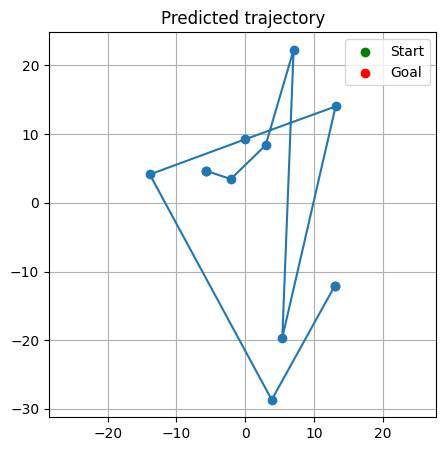

In [8]:
samples = diffusion.sample(cond)                       # (B, T*D)
sample = samples[0].view(dataset.T, dataset.D)         # (T, 2)
visualize_waypoints_2d(sample, "Predicted trajectory")


In [ ]:
ls = [1, 2, 3, 4, 5]
sum = 0
for i in ls:
    sum += i
    print(sum)

1
3
6
10
15
